<a href="https://colab.research.google.com/github/harshmudgil97/book_recommender_system/blob/main/Final_Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction


---


During the last few decades, recommender systems have taken more and more place in our lives. From e-commerce to online advertisement, recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users. Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

#Data Description


---



**The Book-Crossing dataset comprises 3 files.**

**● Users**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

**● Books**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title,Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S,Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

**● Ratings**
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


In [ ]:
df_books=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module 4: Machine Learning/Capstone Project - 2/BOOK RECOMMENDATION SYSTEM - Harsh Mudgil/Datasets/Books.csv')
df_ratings=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module 4: Machine Learning/Capstone Project - 2/BOOK RECOMMENDATION SYSTEM - Harsh Mudgil/Datasets/Ratings.csv')
df_user=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module 4: Machine Learning/Capstone Project - 2/BOOK RECOMMENDATION SYSTEM - Harsh Mudgil/Datasets/Users.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_books['Book-Author'].fillna('Unknown',inplace=True)

In [ ]:
# Define a function to combine to columns namely title and author
def change_title(str1,str2):
  '''Change the title of books'''
  str1 = str1 +" "+'by' +" "+str2
  return str1

In [ ]:
df_books.shape

(271360, 8)

In [ ]:
# Create a new column for title
df_books['new_title'] = df_books.apply(lambda x : change_title(x['Book-Title'],x['Book-Author']),axis = 1)

In [ ]:
# Get rid of duplications
df_books = df_books.drop_duplicates(subset='new_title',keep='first')

In [ ]:
df_books.shape

(251185, 9)

#Primary Inspection

In [ ]:
p=print

In [ ]:
df_merged = df_ratings.merge(df_books,how='inner',on='ISBN')
df_merged = df_merged.merge(df_user,how='inner',on='User-ID')


In [ ]:
df_merged.shape
df_merged['Title-Lenght'] = df_merged['Book-Title'].apply(len)
df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'], errors='coerce').fillna(2099, downcast = 'infer')

In [ ]:
df_merged.describe(include='all')

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Lenght
count,916933.00000,916933,916933.000000,916933,916933,916933.000000,916931,916933,916933,916929,916933,916933,671659.000000,916933.000000
unique,NaN,250075,NaN,241061,101587,NaN,16542,250074,250074,250071,250075,21418,NaN,NaN
top,NaN,0971880107,NaN,Wild Animus,Nora Roberts,NaN,Ballantine Books,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus by Rich Shapero,"toronto, ontario, canada",NaN,NaN
freq,NaN,2502,NaN,2502,7645,NaN,30011,2502,2502,2502,2502,13115,NaN,NaN
mean,140202.83165,NaN,2.825417,NaN,NaN,1968.353922,NaN,NaN,NaN,NaN,NaN,NaN,37.340037,34.243288
std,80804.41894,NaN,3.848183,NaN,NaN,230.251189,NaN,NaN,NaN,NaN,NaN,NaN,14.073900,23.618870
min,2.00000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,69697.00000,NaN,0.000000,NaN,NaN,1991.000000,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,16.000000
50%,140410.00000,NaN,0.000000,NaN,NaN,1997.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,28.000000
75%,211426.00000,NaN,7.000000,NaN,NaN,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,45.000000,48.000000


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916933 entries, 0 to 916932
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              916933 non-null  int64  
 1   ISBN                 916933 non-null  object 
 2   Book-Rating          916933 non-null  int64  
 3   Book-Title           916933 non-null  object 
 4   Book-Author          916933 non-null  object 
 5   Year-Of-Publication  916933 non-null  int64  
 6   Publisher            916931 non-null  object 
 7   Image-URL-S          916933 non-null  object 
 8   Image-URL-M          916933 non-null  object 
 9   Image-URL-L          916929 non-null  object 
 10  new_title            916933 non-null  object 
 11  Location             916933 non-null  object 
 12  Age                  671659 non-null  float64
 13  Title-Lenght         916933 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 104.9+ MB


In [ ]:
df_merged.loc[df_merged['ISBN'].str.endswith('X')].head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Lenght
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"tyler, texas, usa",NaN,20
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"cincinnati, ohio, usa",23.0,20
30,2313,080901548X,0,The Dark Child : The Autobiography of an Afric...,Camara Laye,1954,"Farrar, Straus and Giroux",http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,The Dark Child : The Autobiography of an Afric...,"cincinnati, ohio, usa",23.0,52


## Conclusion: Some titles have same ISBN.

## **Unique Book Titles**

In [ ]:
len(df_merged['Book-Title'].unique())

241061

## **Unique ISBN**

In [ ]:
len(df_merged['ISBN'].unique())

250075

## **Unique Users**


In [ ]:
len(df_merged['User-ID'].unique())

85504

## **Publication Years**

In [ ]:
df_merged['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970, 1978, 1993,
       1989, 1995, 1990, 1992, 1950, 1991, 1999, 1954, 1988, 2003, 2004,
       2000, 1983, 1985, 1982, 1956, 1979, 1986, 1975,    0, 1976, 1977,
       1980, 1981, 1974, 1957, 1958, 1960, 1963, 1969, 1972, 1961, 1971,
       1953, 1968, 1973, 1967, 1962, 1937, 1959, 1955, 2005, 1945, 1965,
       1964, 1927, 2020, 2050, 1920, 1966, 1952, 1930, 1940, 1942, 1947,
       1925, 1923, 2030, 1951, 1936, 1946, 1943, 2099, 1928, 1941, 2011,
       1948, 1901, 1932, 1939, 1944, 1938, 1902, 1929, 1900, 1911, 1949,
       1926, 1933, 1922, 1897, 2026, 1906, 1806, 1935, 2006, 2037, 1921,
       2024, 2038, 1924, 1378, 2008, 1934, 1909, 1931, 1904, 1917, 2012,
       1914, 1376, 1908, 1919])

# **Observation:-** We can clearly see that their are some noise values in the Year of Publication features :-
### 1. **String Noise Values -** such as 'DK Publishing Inc' and 'Gallimard.
### 2. **Integer Noise Values -** Since this data was collected in august 2004, so any year value greater than 2004 is a noise value.

In [ ]:
len(df_merged['Publisher'].unique())

16543

# **Preprocessing and Feature Engineering**

## 1. Feature Engineering on Location

In [ ]:
def get_country(x):
  return x.split(',')[-1]
  

In [ ]:
df_location = df_user.copy(deep=True)
df_location['country'] = df_user['Location'].apply(get_country)

In [ ]:
df_merged['Location'] = df_merged['Location'].apply(get_country)

1. Age

In [ ]:
# Create age groups using age column
bins = [-1,12,20,50,100]
labels = ['Kid','Teenager','Adult','Old']
df_merged['age_bins'] = pd.cut(x=df_merged['Age'], bins=bins,labels=labels)

##Capping Outlier



1. Age

In [ ]:
# Number of outliers
outliers = sum(df_merged['Age']>90)
print(outliers)

2872


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


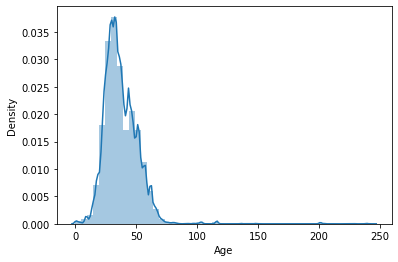

In [ ]:
# Plot Distribution of Age
sns.distplot(df_merged['Age'].dropna())
# Handling outliers by randomly replacing age >90 by values between 90 and 100
age2 = df_merged['Age'].copy()
random_age2 = np.random.randint(90,100,outliers)
age2[df_merged['Age']>90]=random_age2
df_merged['Age'] = age2

## Handling Missing Value

In [ ]:
# Missing Value Count Function
def show_missing(y):
    missing = y.columns[y.isnull().any()].tolist()
    return missing

def print_missing(x):
  # Missing data counts and percentage
  print('Missing Data Count')
  print(x[show_missing(x)].isnull().sum().sort_values(ascending = False))
  print('--'*50)
  print('Missing Data Percentage')
  print(round(x[show_missing(x)].isnull().sum().sort_values(ascending = False)/len(x)*100,2))

In [ ]:
print_missing(df_user)

Missing Data Count
Age    110762
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Age    39.72
dtype: float64


In [ ]:
print_missing(df_books)

Missing Data Count
Image-URL-L    3
Publisher      2
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Image-URL-L    0.0
Publisher      0.0
dtype: float64


In [ ]:
print_missing(df_ratings)

Missing Data Count
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Series([], dtype: float64)


In [ ]:
print_missing(df_location)

Missing Data Count
Age    110762
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Age    39.72
dtype: float64


In [ ]:
print_missing(df_merged)

Missing Data Count
age_bins       247826
Age            245274
Image-URL-L         4
Publisher           2
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
age_bins       27.03
Age            26.75
Image-URL-L     0.00
Publisher       0.00
dtype: float64


1. Age

In [ ]:
# Null values in age column
nulls = sum(df_merged['Age'].isnull())
print('Null values in Age: ',nulls)

Null values in Age:  245274


In [ ]:
# Replacing null values
median = df_merged['Age'].median()
std = df_merged['Age'].std()
random_age = np.random.randint(median - std, median + std, size = nulls)
age = df_merged['Age'].copy()
age[pd.isnull(age)] = random_age
df_merged['Age'] = age
df_merged['Age'] = df_merged['Age'].astype(int)

2. Publisher and Author

In [ ]:
df_merged[['Book-Author', 'Publisher']] = df_merged[['Book-Author', 'Publisher']].fillna('Unknown')

## Duplicates

In [ ]:
# Selected Poems title
df_merged[df_merged['Book-Title']== 'Selected Poems'][['Book-Title','Book-Author']]

,Book-Title,Book-Author
1849,Selected Poems,Rita Dove
2500,Selected Poems,Gwendolyn Brooks
18376,Selected Poems,R. Jeffers
19954,Selected Poems,Michael Mc Clure
28158,Selected Poems,John Ashbery
41312,Selected Poems,Rita Dove
58746,Selected Poems,E. E. Cummings
94931,Selected Poems,Rita Dove
96886,Selected Poems,John Ashbery
137709,Selected Poems,K. Patchen


###Observations:
####Some books occur more than once because they are different editions of the same books while others have similar names but different authors.

In [ ]:
# Create age groups using age column
bins = [-1,12,20,50,100]
labels = ['Kid','Teenager','Adult','Old']
df_merged['age_bins'] = pd.cut(x=df_merged['Age'], bins=bins,labels=labels)

In [ ]:
df_merged.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Lenght,age_bins
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,usa,42,20,Adult
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult


In [ ]:
# Calculating the rating count and mean rating given to each book by the user.

rating_count = df_merged.groupby('Book-Title')['Book-Rating'].count().to_frame()
rating_mean = df_merged.groupby('Book-Title')['Book-Rating'].mean().to_frame()

In [ ]:
# Renaming the column names before merging them with the final dataset.

rating_count.rename(columns={'Book-Rating':'Rating-Count'}, inplace=True)
rating_mean.rename(columns={'Book-Rating':'Rating-Mean'}, inplace=True)

In [ ]:
df_merged = pd.merge(df_merged, rating_count, on='Book-Title', how='inner')
df_merged = pd.merge(df_merged, rating_mean, on='Book-Title', how='inner')

In [ ]:
# rounding off the rating mean feature to 2 decimal points
df_merged['Rating-Mean'] = df_merged['Rating-Mean'].round(2)

In [ ]:
df_merged.drop(columns=['Image-URL-M','Image-URL-S','Image-URL-L'],inplace=True)

In [ ]:
df_merged.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,42,20,Adult,60,2.93
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93


## **Using IMDB Formula to calculate the Weighted Rating for our books**

In [ ]:
# Calculating the mean vote across the whole df
C = df_merged['Rating-Mean'].mean()
C

2.8254419134221482

In [ ]:
# Calculating the minimum votes required to be listed in the top 5%
m = rating_count.quantile(.95)[0]
m

12.0

In [ ]:
# IMDB formula; source: https://tutorialedge.net/python/building-imdb-top-250-clone-pandas/
def weighted_rating(x, m=m, C=C):
    v = x['Rating-Count']
    R = x['Rating-Mean']

    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
df_merged_updated=df_merged[df_merged['Book-Rating']!=0]

In [ ]:
df_merged_updated.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,2,20,Kid,60,2.93


In [ ]:
# Create relevant sub-dataset
df_top_10 = df_merged_updated.copy().loc[df_merged_updated['Rating-Count'] >= m]
df_top_10.shape

(163365, 14)

In [ ]:
df_top_10['Score'] = df_top_10.apply(weighted_rating, axis=1)

# **2. Exploratory Data Analysis**

## Ratings Count

In [ ]:
rating_count=df_ratings['Book-Rating'].value_counts().reset_index().sort_values('Book-Rating',ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Ratings Count')

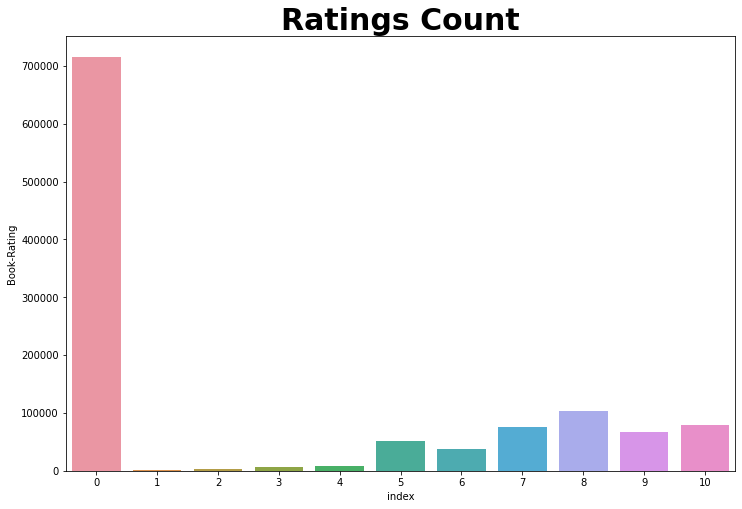

In [ ]:
plt.figure(figsize=(12,8))
ax=sns.barplot(rating_count['index'],rating_count['Book-Rating'])
ax.set_title('Ratings Count',fontsize=30,fontweight='bold')

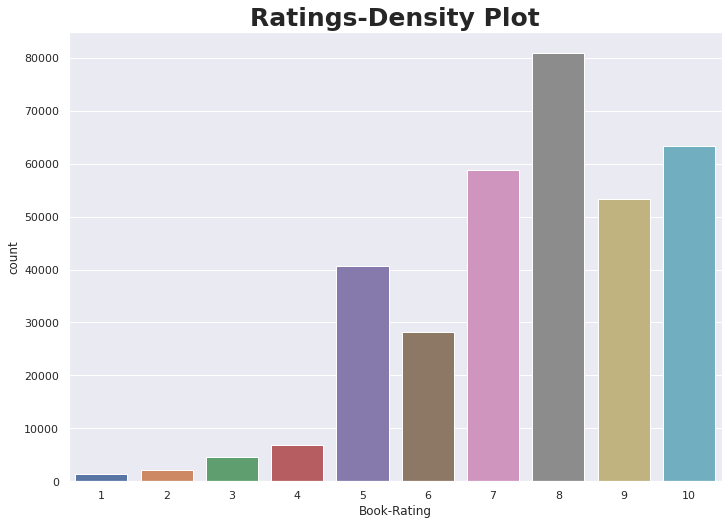

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# df_merged_updated = df_merged_updated[df_merged['Book-Rating']!=0]
sns.countplot(x='Book-Rating', data=df_merged_updated).set_title('Ratings-Density Plot', weight='bold').set_fontsize('25')

## Author

In [ ]:
auth_rating=df_merged.groupby(['Book-Author'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Author V/S Ratings')

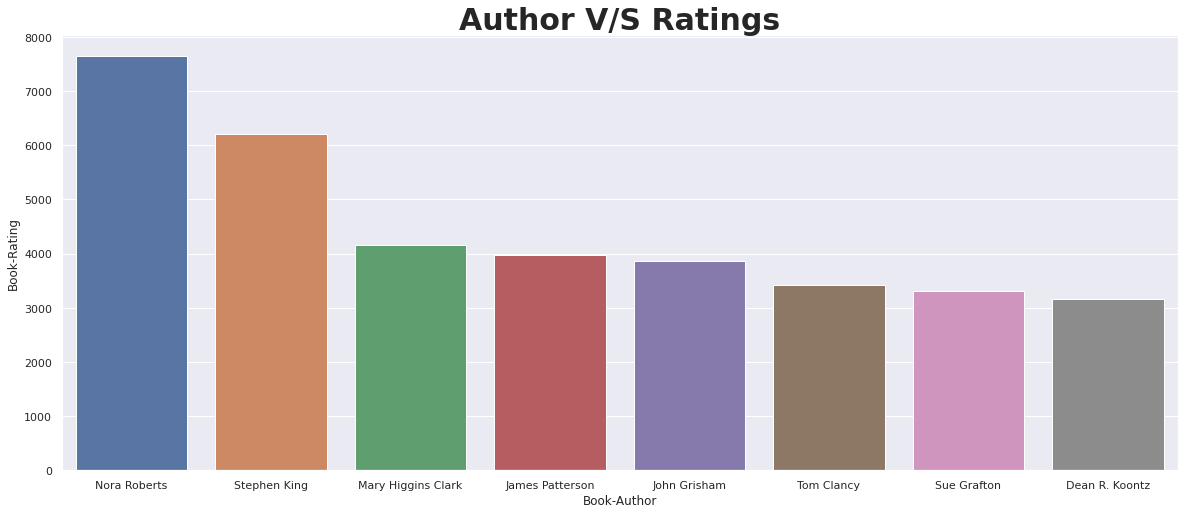

In [ ]:
plt.figure(figsize=(20,8))
ax=sns.barplot(auth_rating[auth_rating['Book-Rating']>3000]['Book-Author'],auth_rating[auth_rating['Book-Rating']>3000]['Book-Rating'])
ax.set_title('Author V/S Ratings', fontsize=30,fontweight='bold')


In [ ]:
book_rating=df_merged.groupby(['Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

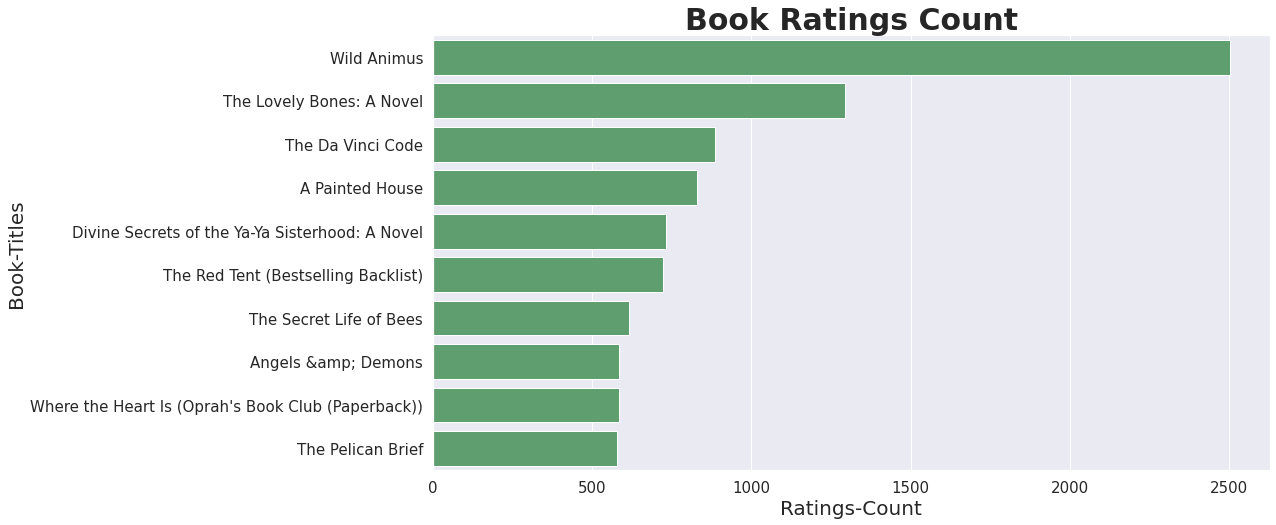

In [ ]:
plt.figure(figsize=(15,8))
ax=sns.barplot(book_rating['Book-Rating'][:10],book_rating['Book-Title'][:10],color='g')
ax.set_title('Book Ratings Count', fontsize=30,fontweight='bold')
ax.set_xlabel('Ratings-Count',fontsize=20)
ax.set_ylabel('Book-Titles',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

## Location

In [ ]:
#Identifying what % of customers are coming from different countries
df_location = pd.DataFrame(df_location.country.value_counts(normalize=True)).reset_index()
df_location.columns = ['countries','value_counts']

#Labeling countries with low customer % as other
df_location['countries'] = df_location.apply(lambda x: 'other' if (x['value_counts'] < 0.01 or x['countries'] == '') else x['countries'],axis=1)

#Grouping the customer % from 'other' countries 
df_location = df_location.groupby('countries')['value_counts'].sum().reset_index()

In [ ]:
#Every country has now just one occurance
df_location.countries.value_counts()

 australia         1
 italy             1
other              1
 canada            1
 netherlands       1
 portugal          1
 france            1
 germany           1
 usa               1
 new zealand       1
 spain             1
 united kingdom    1
Name: countries, dtype: int64

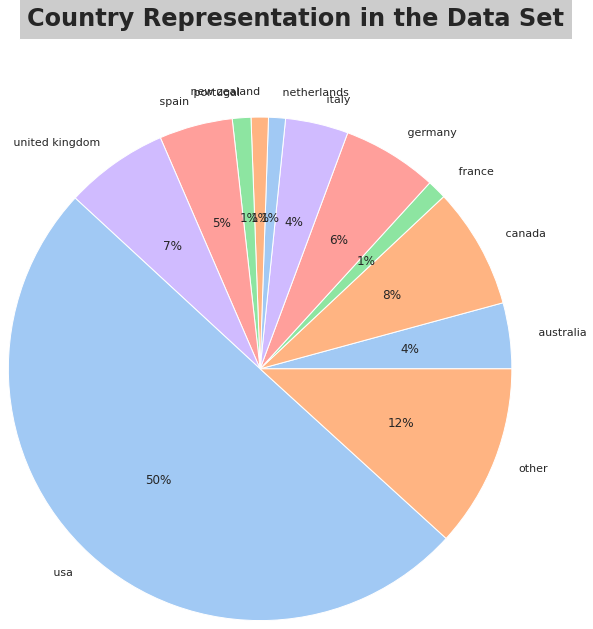

In [ ]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title("Country Representation in the Data Set",bbox={'facecolor':'0.8', 'pad':8},fontsize=24, fontdict={"weight": "bold"},y=1.25,x=0.578)
f = plt.pie(df_location['value_counts'], labels = df_location['countries'], colors = colors, autopct='%.0f%%',radius=1.4)

# **Insight**: Most customers are from United states of America, followd by Canada, United Kingdom and Germany

*Countries with less than 1% customers are labeled as other

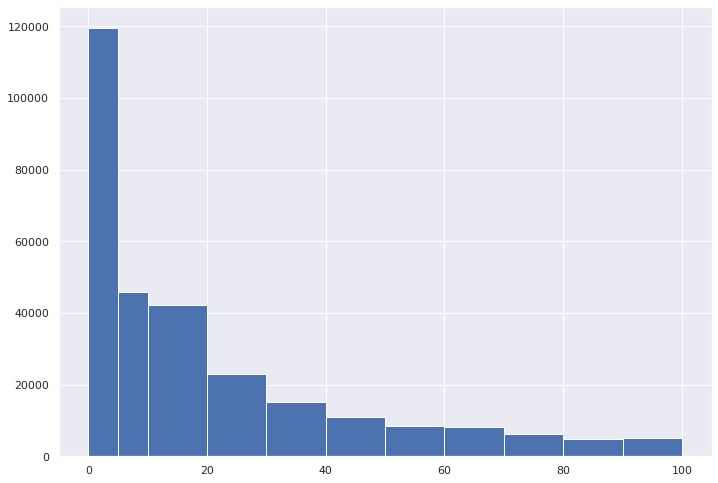

In [ ]:
# Visualizing the rating counts of the users. 
df_merged_updated['Rating-Count'].hist(bins=[0,5,10,20,30,40,50,60,70,80,90,100])

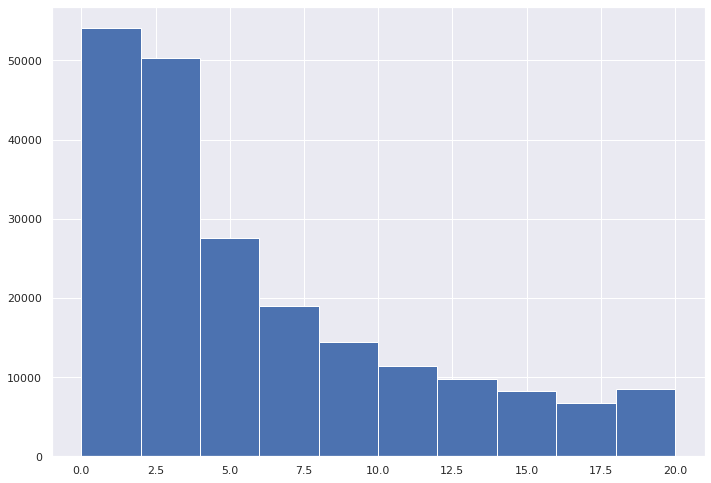

In [ ]:
# Visualizing the rating counts of the users in the range between 0 to 20. 
df_merged_updated['Rating-Count'].hist(bins=[0,2,4,6,8,10,12,14,16,18,20])

## **From this visualization it is evident that most books have been rated by 2 to 5 users only.**

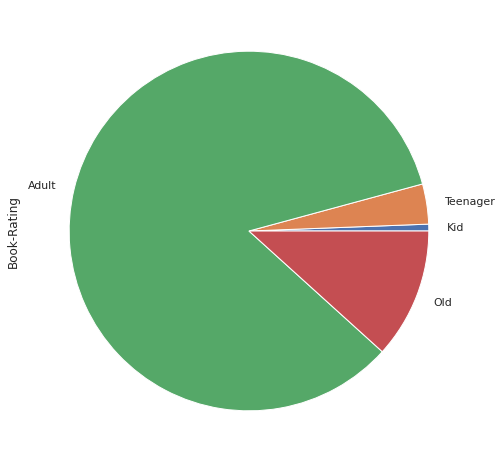

In [ ]:
# Age group that rated books the most
df_merged.groupby('age_bins')['Book-Rating'].count().plot(kind='pie')

In [ ]:
# Which country rates books the most
b1 = df_merged.groupby('Location')['Book-Rating'].count().sort_values(ascending=False).head(5)
b1

Location
 usa               660618
 canada             82214
 united kingdom     29795
 germany            26024
                    21364
Name: Book-Rating, dtype: int64

In [ ]:
# Implicit ratings i.e. Book-Rating = 0
b2 = df_merged[df_merged['Book-Rating']==0].\
groupby('Location')['Book-Rating'].count().sort_values(ascending=False).head(5)

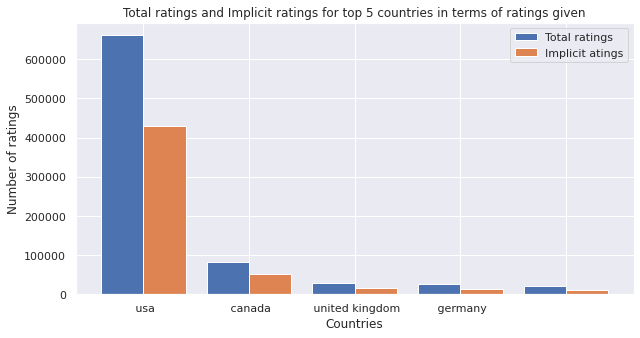

In [ ]:
# Bar plot for Rating comparison 
n= 5
X_axis = np.arange(n)
X = b1.index

plt.figure(figsize=(10,5))  
plt.bar(X_axis - 0.2, b1, 0.4, label = 'Total ratings')
plt.bar(X_axis + 0.2, b2, 0.4, label = 'Implicit atings')
  
plt.xticks(X_axis, X)
plt.xlabel("Countries")
plt.ylabel("Number of ratings")
plt.title("Total ratings and Implicit ratings for top 5 countries in terms of ratings given")
plt.legend()
plt.show()

In [ ]:
# Most popular books for different age groups
age_bin_df = df_merged.groupby(['age_bins','Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()
age_bin_df.rename(columns={'Book-Title':'Number of times rated'},inplace=True)

####<b>Note: </b>
####Users from each age category can be said to have some similar book preferences, we will later use Age as a relevance to recommend books for implicit ratings.

# **Preparing the Data for Model Building.**

## Removing Unwanted Values from the Dataset.
### Here the Year-Of-Publication is in object Dtype, it should ideally be in  numeric Dtype. Let us explore this feature a bit more.

## **1. Cleaning the Feature - Year of Publication**

In [ ]:
# Visually inspecting this feature by observing it's unique values.
df_merged_updated['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970,    0, 1978,
       1993, 1989, 1995, 1990, 1957, 1992, 1950, 1991, 1999, 1954, 1988,
       2003, 2004, 1977, 2000, 1983, 1985, 1986, 1982, 1956, 1979, 1976,
       1981, 1980, 1974, 1958, 1960, 1963, 1969, 1971, 1973, 1972, 1961,
       1953, 1962, 1937, 1968, 1959, 1955, 2005, 1975, 1965, 1920, 1943,
       1964, 1967, 1927, 2020, 2050, 1952, 1966, 1930, 1940, 1942, 1946,
       1947, 1925, 1923, 2030, 1936, 1928, 1941, 1951, 1901, 2011, 1939,
       1945, 1932, 1902, 1929, 1911, 1949, 1926, 2026, 1906, 1806, 1933,
       1935, 1938, 2006, 2037, 1948, 2099, 2038, 1900, 1904, 1924, 1378,
       1934, 1944, 1931, 1376, 1908])

## **Observation:-** We can clearly see that their are some noice values in the Year of Publication features :-
### 1. **String Noice Values -** such as 'DK Publishing Inc' and 'Gallimard.
### 2. **Integer Noice Values -** Since this data was collected in august 2004, so any year value greater than 2004 is a noice value.

In [ ]:
# Casting Year-Of-Publication to numeric datatype and removing all String Noice Values using coerce functionality.

df_merged_updated['Year-Of-Publication'] = pd.to_numeric(df_merged_updated['Year-Of-Publication'], 'coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Cross checking the column to check if the string based noice values are removed or not.
df_merged_updated['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970,    0, 1978,
       1993, 1989, 1995, 1990, 1957, 1992, 1950, 1991, 1999, 1954, 1988,
       2003, 2004, 1977, 2000, 1983, 1985, 1986, 1982, 1956, 1979, 1976,
       1981, 1980, 1974, 1958, 1960, 1963, 1969, 1971, 1973, 1972, 1961,
       1953, 1962, 1937, 1968, 1959, 1955, 2005, 1975, 1965, 1920, 1943,
       1964, 1967, 1927, 2020, 2050, 1952, 1966, 1930, 1940, 1942, 1946,
       1947, 1925, 1923, 2030, 1936, 1928, 1941, 1951, 1901, 2011, 1939,
       1945, 1932, 1902, 1929, 1911, 1949, 1926, 2026, 1906, 1806, 1933,
       1935, 1938, 2006, 2037, 1948, 2099, 2038, 1900, 1904, 1924, 1378,
       1934, 1944, 1931, 1376, 1908])

In [ ]:
df_merged_updated[(df_merged_updated['Year-Of-Publication']== 0)]['Book-Rating'].value_counts()

In [ ]:
# Removing all the integer Noice Values from the Dataset.
df_merged_updated = df_merged_updated[(df_merged_updated['Year-Of-Publication']<=2006)]
df_merged_updated.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,2,20,Kid,60,2.93


In [ ]:
df_merged_updated['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970, 1978, 1993,
       1989, 1995, 1990, 1957, 1992, 1950, 1991, 1999, 1954, 1988, 2003,
       2004, 1977, 2000, 1983, 1985, 1986, 1982, 1956, 1979, 1976, 1981,
       1980, 1974, 1958, 1960, 1963, 1969, 1971, 1973, 1972, 1961, 1953,
       1962, 1937, 1968, 1959, 1955, 1975, 1965, 1920, 1943, 1964, 1967,
       1927, 1952, 1966, 1930, 1940, 1942, 1946, 1947, 1925, 1923, 1936,
       1928, 1941, 1951, 1901, 1939, 1945, 1932, 1902, 1929, 1911, 1949,
       1926, 1906, 1806, 1933, 1935, 1938, 1948, 1900, 1904, 1924, 1378,
       1934, 1944, 1931, 1376, 1908])

In [ ]:
# The percentage of Data lost while cleaning the Year-of_publication Feature.
percentage_of_data_lost = (1031136 - df_merged_updated.shape[0])*100/1031136
percentage_of_data_lost

67.52843465847376

### **Therefore, after cleaning the dataset based upon Year-Of-Publication Feature, we lost only a miniscule amount of 1.3% data.**

## 1. Selecting Books with Optimum Number of Ratings

### As we all know that building any recommendation system requires a lot of data . Recommendations should be relevant otherwise they can cause a nuisance to the customers. So, we have set a threshold number of ratings per book in order to get optimal recommendations for our users.

In [ ]:
# #Selecting Books which have been rated more than 8 times
# v = df_merged_updated['ISBN'].value_counts()
# df_merged_updated = df_merged_updated[df_merged_updated['ISBN'].isin(v.index[v.gt(14)])]

In [ ]:
books_reduce=df_merged_updated.groupby(['ISBN'])['Book-Rating'].count().reset_index().sort_values('Book-Rating',ascending=False)

In [ ]:
reduced_books=books_reduce[books_reduce['Book-Rating']>10]['ISBN']

In [ ]:
df_merged_updated=df_merged_updated.merge(reduced_books,how='inner',left_on='ISBN',right_on='ISBN')

In [ ]:
df_merged_updated.shape

(111830, 14)

# **2. Defining the Optimum Book reader**:-

### We can't take every user's rating at facevalue because if the user is a novice reader with only an experience of reading a couple of books, his/her ratings might not be much relevant for finding similarity among books.

### **Therefore as a general rule of thumb we choosing only those User's who have rated atleast 15 Books for builing the recommendation system.**

In [ ]:
# #Selecting users which rated more than 4 Users
# u = df_merged_updated['User-ID'].value_counts()
# df_merged_updated = df_merged_updated[df_merged_updated['User-ID'].isin(u.index[u.gt(4)])]

In [ ]:
# df_merged_updated['User-ID'].value_counts()

In [ ]:
# df_merged_updated.shape

In [ ]:
# Size of dataset rows before the User selection operation.
df_size_before_removing_Novice_readers = df_merged_updated.shape[0]
df_size_before_removing_Novice_readers

111830

In [ ]:
# Storing the value counts of User-ID's in a new variable named counts1
counts1 = df_merged_updated['User-ID'].value_counts()

# Removing the User-ID's which have rated less than 10 books.
df_merged_updated= df_merged_updated[df_merged_updated['User-ID'].isin(counts1[counts1 >=10].index)].reset_index()
df_merged_updated.drop(columns='index', inplace=True)

In [ ]:
df_merged_updated.shape

(51506, 14)

In [ ]:
# Size of dataset rows after the User selection operation.
df_size_after_removing_Novice_readers = df_merged_updated.shape[0]
df_size_after_removing_Novice_readers

51506

In [ ]:
# Percentage of Data lost while removing the noice readers.
percentage_of_data_lost_after_removing_Novice_readers = (df_size_before_removing_Novice_readers - df_size_after_removing_Novice_readers)*100/df_size_before_removing_Novice_readers
percentage_of_data_lost_after_removing_Novice_readers

53.94259143342573

In [ ]:
df_merged_updated.shape

(51506, 14)

# 1. Simple Model For Book Recommendation

## **Recommendations Based upon Top 10 Books with highest average rating**

In [ ]:
top_rated = df_merged_updated[['Book-Title', 'Rating-Mean']]
top_rated = top_rated.groupby(['Book-Title'])['Rating-Mean'].mean().to_frame()
top_rated.sort_values(by='Rating-Mean', ascending=False).head(10)

,Rating-Mean
Book-Title,
The Baby Book: Everything You Need to Know About Your Baby from Birth to Age Two,8.46
Die unendliche Geschichte: Von A bis Z,8.07
Free,8.02
There's Treasure Everywhere--A Calvin and Hobbes Collection,7.88
Harry Potter y el cÃ¡liz de fuego,7.88
Warchild,7.62
"Jesus Freaks: DC Talk and The Voice of the Martyrs - Stories of Those Who Stood For Jesus, the Ultimate Jesus Freaks",7.53
El Hobbit,7.48
A Night Without Armor : Poems,7.25


## 2. Interactive: Top 10 books for respective authors

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
# Recommending Books Based Upon Authors:-
@interact
def recommend_books_based_upon_author( Book_Author = list(df_top_10['Book-Author'].value_counts().index)):
  a = df_top_10[df_top_10['Book-Author']==Book_Author][['Book-Title', 'Rating-Mean']]
  a = a.groupby(['Book-Title'])['Rating-Mean'].mean().to_frame()
  a = a.sort_values(by = 'Rating-Mean', ascending=False)
  return a.head(10)
#Load the drive to use the interactive feature

interactive(children=(Dropdown(description='Book_Author', options=('Nora Roberts', 'Stephen King', 'James Patt…

# By using the above drop down window, you can see the books from each publishing house that lie in the top 10 % based upon the Imdb criteria that was shown above.

## 3. Memory Based Knn Model

In [ ]:
df_Knn = df_merged_updated.copy(deep=True)

In [ ]:
df_Knn['Score'] = df_merged_updated.apply(weighted_rating, axis=1)

In [ ]:
df_Knn.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean,Score
0,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93,2.912574
1,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,26,20,Adult,60,2.93,2.912574


In [ ]:
#df_Knn.drop(columns=['Book-Title','Title-Lenght','age_bins'],inplace=True)

In [ ]:
df_Knn.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean,Score
0,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93,2.912574
1,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,26,20,Adult,60,2.93,2.912574


In [ ]:
# Dropping the columns that aren't much useful for KNN recommendation system.
df_Knn.drop(columns=['ISBN',	'Book-Author',	'Year-Of-Publication',	'Publisher','Age','Location', 'Book-Rating', 'Rating-Count', 'Rating-Mean','Book-Title','Title-Lenght','age_bins'], inplace=True)

In [ ]:
# Calculating the total number of books in the dataset and the number of books used in the recommendation system.

Number_of_books_in_dataset = len(df_books['Book-Title'].unique())
Number_of_books_considered_for_recommendation = len(df_Knn['new_title'].unique())

In [ ]:
# Percentage of books considered for recommendation.

per_books_in_recommendation_system = (Number_of_books_considered_for_recommendation*100)/Number_of_books_in_dataset
per_books_in_recommendation_system

1.65362297891672

In [ ]:
# Building the Final dataframe for the KNN Model.
df_final = pd.pivot_table(data=df_Knn, index='new_title', columns='User-ID', values='Score').fillna(0)

In [ ]:
df_final.shape

(4004, 2117)

In [ ]:
df_final.head(20)

User-ID,243,254,507,638,805,882,929,1131,1424,1435,1733,1848,2033,2110,2276,2313,2337,2766,2891,2977,3145,3167,3346,3363,3371,3373,3827,3917,4017,5037,5476,5499,5539,5582,6073,6238,6242,6251,6323,6532,...,273113,273190,273344,273718,273813,273976,273979,274004,274056,274061,274301,274308,274325,274393,274549,274634,274808,275154,275970,275994,276050,276165,276231,276463,276521,276641,276680,277157,277427,277523,277945,278026,278137,278188,278194,278418,278535,278582,278633,278843
new_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot by Stephen King,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
"14,000 Things to Be Happy About by Barbara Ann Kipfer",0.0,0.000000,0.0,0.000000,0.0,0.0,3.549633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
16 Lighthouse Road by Debbie Macomber,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1984 by George Orwell,0.0,4.505026,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.505026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1st to Die: A Novel by James Patterson,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.479914,0.0,0.0,0.0
2001: A Space Odyssey by Arthur C. Clarke,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2010: Odyssey Two by Arthur C. Clarke,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
204 Rosewood Lane by Debbie Macomber,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2061: Odyssey Three by Arthur C. Clarke,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
# converting the sparse matrix into condensed matrix using scipy.sparse functionality.
from scipy.sparse import csr_matrix

df_matrix = csr_matrix(df_final.values)

In [ ]:
# Building a KNN model with Cosine Similarity as the target metric for calculating the distances.

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors=5)
model_knn.fit(df_final)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
# Building item to item recommendation model for the book readers
def recommend(movie, n_values=11):
  distances, indices = model_knn.kneighbors(df_final.loc[movie,:].values.reshape(1, -1), n_neighbors = n_values)
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'The Top {n_values - 1} Recommendations for Users who have read book {movie} are shown below:-')
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, df_final.index[indices.flatten()[i]], distances.flatten()[i]))

In [ ]:
recommend('9-11 by Noam Chomsky', n_values=10)

The Top 9 Recommendations for Users who have read book 9-11 by Noam Chomsky are shown below:-
1: Die Weiss Lowin / Contemporary German Lit by Henning Mankell, with distance of 0.6220355269907728.
2: The First Counsel by Brad Meltzer, with distance of 0.6220355269907728.
3: Schlafes Bruder by Robert Schneider, with distance of 0.6220355269907728.
4: Herzsprung by Ildiko Kurthy, with distance of 0.6220355269907728.
5: Due di due (Bestsellers) by Andrea De Carlo, with distance of 0.6220355269907728.
6: MÃ?Â¶rder ohne Gesicht. by Henning Mankell, with distance of 0.6220355269907728.
7: UN Viejo Que Leia Novelas De Amor/the Old Men Who Read Love Stories (ColecciÃ³n Andanzas) by Luis Sepulveda, with distance of 0.6220355269907728.
8: Vernon God Little: A 21st Century Comedy in the Presence of Death by D. B. C. Pierre, with distance of 0.6220355269907728.
9: Lauf, Jane, lauf. Roman. by Joy Fielding, with distance of 0.6220355269907728.


# **Now, let us have a live demonstration for the model that we have built on our website.**

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = df_merged_updated.groupby(['User-ID','Book-Title'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 51474


,User-ID,Book-Title,Book-Rating
0,243,A Monk Swimming,2.584963
1,243,A Painted House,3.000000
2,243,Chicken Soup for the Soul (Chicken Soup for th...,2.584963
3,243,Manhattan Hunt Club,2.807355
4,243,Me Talk Pretty One Day,3.321928


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(interactions_full_df['Book-Title'].unique())

LabelEncoder()

In [ ]:
from sklearn.model_selection import train_test_split
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, 
                                   test_size=0.20,
                                   stratify=interactions_full_df['User-ID'],
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 41179
# interactions on Test set: 10295


In [ ]:
interactions_train_df['Book-Title'] = le.transform(interactions_train_df['Book-Title'])
interactions_test_df['Book-Title'] = le.transform(interactions_test_df['Book-Title'])

interactions_train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,User-ID,Book-Title,Book-Rating
9909,49422,2445,2.807355
18015,95359,570,2.807355
38987,209631,3539,3.169925
29103,152099,181,3.169925
17397,92132,1602,3.321928


In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='User-ID', 
                                                          columns='Book-Title', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head()

Book-Title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3896,3897,3898,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
243,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,3.321928,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.321928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
805,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.459432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[243, 254, 507, 638, 805, 882, 929, 1131, 1424, 1435]

In [ ]:
from scipy.sparse.linalg import svds
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-0.00724634,  0.00996336,  0.00351604, ..., -0.00505244,
         0.01698068, -0.01716532],
       [ 0.01999361,  0.01714334, -0.00708701, ...,  0.00967217,
        -0.01213437,  0.04961019],
       [-0.00082438,  0.00373193,  0.02785687, ...,  0.00733474,
        -0.01239809,  0.0189662 ],
       ...,
       [-0.01558191,  0.00627614, -0.01819068, ...,  0.00801888,
        -0.01847432,  0.00909796],
       [ 0.00443059,  0.00718859, -0.00502944, ..., -0.0036671 ,
         0.03568072, -0.01207431],
       [ 0.00677983,  0.00512601,  0.00986354, ..., -0.00277352,
         0.01527475, -0.00336597]])

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,243,254,507,638,805,882,929,1131,1424,1435,1733,1848,2033,2110,2276,2313,2337,2766,2891,2977,3145,3167,3346,3363,3371,3373,3827,3917,4017,5037,5476,5499,5539,5582,6073,6238,6242,6251,6323,6532,...,273113,273190,273344,273718,273813,273976,273979,274004,274056,274061,274301,274308,274325,274393,274549,274634,274808,275154,275970,275994,276050,276165,276231,276463,276521,276641,276680,277157,277427,277523,277945,278026,278137,278188,278194,278418,278535,278582,278633,278843
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.007246,0.019994,-0.000824,0.030842,0.001755,0.005286,0.004317,-0.004537,0.000070,0.005700,0.006583,0.009916,-0.007333,0.015876,0.011313,0.001662,-0.001895,0.021622,0.002853,0.000302,-0.002201,0.016236,0.003684,-0.006781,0.005993,-0.000637,0.024354,-0.000273,-0.003166,0.017056,0.006938,0.001329,0.008748,0.003413,0.019999,-0.001093,-0.018839,-0.028750,0.012420,0.011170,...,-0.040568,-0.002427,0.000927,0.019543,-0.002746,0.010856,-0.009261,0.025777,-0.000751,0.159036,0.016003,0.016190,-0.005188,0.000595,0.006214,0.012382,0.001321,0.001197,-0.001351,0.008890,0.038089,0.003600,0.005830,0.007862,0.006693,-0.000890,0.022623,-0.001384,0.016972,-0.000673,-0.006213,-0.012652,0.008097,-0.003371,-0.000642,0.003152,-0.001783,-0.015582,0.004431,0.006780
1,0.009963,0.017143,0.003732,0.001287,0.013062,0.002137,0.002196,0.009207,0.004807,0.009415,0.002848,0.003862,0.025595,0.003442,0.002774,0.001336,0.008745,-0.002728,0.011225,0.009553,0.000272,0.004133,0.000792,0.005983,0.000042,0.001692,0.006458,0.000135,0.011806,0.002283,-0.004989,-0.001371,0.004130,0.004909,0.001898,0.001254,0.019057,0.030032,0.001699,-0.001387,...,0.005482,0.008685,0.001633,-0.005799,0.007002,0.007668,0.012559,0.008336,0.004630,-0.010879,0.022877,-0.003748,0.006902,0.007448,0.001362,-0.001191,0.006469,0.003963,0.003347,0.000073,0.019155,0.013184,0.008704,0.004727,0.002902,0.002484,-0.006008,0.000014,0.001183,0.000206,0.000710,0.000647,0.006645,0.002849,0.000765,0.001964,0.000802,0.006276,0.007189,0.005126
2,0.003516,-0.007087,0.027857,0.033740,-0.006072,0.030824,-0.002481,-0.002871,0.004529,-0.006252,0.045878,0.009513,-0.029860,0.022120,0.022949,-0.004362,-0.004832,-0.040267,-0.022996,-0.006969,0.012378,-0.009541,-0.006686,0.012447,0.032551,0.011963,-0.052678,-0.004589,-0.054560,0.023892,0.018031,0.090937,0.011083,0.058711,-0.013002,-0.010372,-0.020692,-0.054549,-0.029616,0.019428,...,0.337408,-0.008885,-0.017180,-0.029190,-0.005712,-0.007211,0.051855,-0.061324,-0.014658,0.278069,-0.008047,0.110311,0.012524,0.001746,0.004220,0.015069,-0.019858,0.003855,-0.018351,0.024081,-0.017845,0.149947,0.028390,-0.005230,-0.000859,-0.006004,-0.026678,0.025697,0.028633,0.144008,0.089993,-0.003225,-0.015650,-0.002982,0.007062,0.028667,0.000457,-0.018191,-0.005029,0.009864
3,-0.126394,0.344304,0.081690,0.255329,0.026798,0.026129,0.036543,-0.038164,0.009536,0.004155,0.000347,0.072195,0.083378,0.058926,0.043288,0.021651,0.154165,0.192328,0.126346,0.032631,0.001369,0.123706,0.070177,-0.045233,0.000200,0.006772,0.201076,0.008875,-0.130832,-0.055066,-0.048033,-0.044856,0.145396,0.304853,0.135282,0.035722,0.109648,0.263192,0.047894,0.050698,...,-0.037697,-0.032124,0.070922,0.050148,-0.014477,0.173210,-0.042045,0.293054,0.018157,0.902327,-0.031788,-0.120370,-0.017898,0.038861,-0.025799,0.109679,0.023923,0.040573,0.120054,-0.006544,0.384287,0.077859,-0.022350,0.101347,0.036272,0.021659,0.061396,-0.016104,0.085020,-0.055968,-0.016663,-0.003068,0.113528,-0.046708,-0.028958,0.037621,-0.039332,0.050984,0.039841,0.062511
4,0.106426,-0.032957,0.033106,-0.134087,-0.078979,-0.020639,0.028999,0.086200,0.013589,0.044681,-0.088132,0.021587,0.094408,-0.046258,0.162873,-0.018740,-0.004889,0.013813,-0.080965,0.036998,0.078699,0.081244,-0.004287,-0.034318,0.041157,0.096841,-0.100678,0.002988,0.059602,0.056256,0.099400,0.000662,-0.042994,0.117948,-0.037228,0.053545,0.032958,0.378194,0.147991,0.012804,...,0.244926,0.109329,0.014822,-0.065630,0.0802

In [ ]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Book-Title'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Book-Title', 
                                                          right_on = 'Book-Title')[['recStrength','Book-Title']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, items_df=df_merged_updated)

In [ ]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.set_index('User-ID')

In [ ]:
interactions_test_indexed_df.head()

,Book-Title,Book-Rating
User-ID,,
8234,347,3.459432
171118,2219,2.807355
187624,922,2.807355
197775,1196,3.321928
55490,3550,3.459432


In [ ]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['Book-Title']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(df_merged_updated['Book-Title'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['Book-Title']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['Book-Title'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['Book-Title'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id%2)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['Book-Title'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Book-Title'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2116 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.9977659057795046, 'recall@10': 0.9977659057795046}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
12,279,279,289,0.965398,0.965398,11676
31,51,51,51,1.000000,1.000000,16795
25,48,48,48,1.000000,1.000000,104636
41,48,48,48,1.000000,1.000000,153662
339,47,47,47,1.000000,1.000000,95359
241,47,47,47,1.000000,1.000000,98391
232,44,44,44,1.000000,1.000000,114368
510,35,35,35,1.000000,1.000000,123883
216,33,33,33,1.000000,1.000000,60244
464,31,31,31,1.000000,1.000000,158295


# We have obtained 
#● **Recall@5: 99%**
#● **Recall@10: 99%**

In [ ]:
recc = cf_recommender_model.recommend_items(40943)

In [ ]:
recc = le.inverse_transform(recc['Book-Title'])

In [ ]:
recc

array(['The Secret Life of Bees', 'Good in Bed',
       'The Lovely Bones: A Novel',
       'Wicked: The Life and Times of the Wicked Witch of the West',
       'Fahrenheit 451',
       'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
       'The Catcher in the Rye', 'House of Sand and Fog',
       'The Joy Luck Club',
       "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)"],
      dtype=object)

In [ ]:
df_merged_updated[df_merged_updated['User-ID']==40943].head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean
2280,40943,0385730586,10,Sisterhood of the Traveling Pants,ANN BRASHARES,2003,Delacorte Books for Young Readers,Sisterhood of the Traveling Pants by ANN BRASH...,usa,40,33,Adult,130,3.87
2546,40943,0061020710,9,The Color of Magic,Terry Pratchett,2000,HarperTorch,The Color of Magic by Terry Pratchett,usa,40,18,Adult,103,3.19
2695,40943,0312288115,1,Confessions of a Sociopathic Social Climber : ...,Adele Lang,2002,Thomas Dunne Books,Confessions of a Sociopathic Social Climber : ...,usa,40,119,Adult,66,1.59
4919,40943,0743418174,10,Good in Bed,Jennifer Weiner,2002,Washington Square Press,Good in Bed by Jennifer Weiner,usa,40,11,Adult,470,4.04
10012,40943,0440940001,10,Island of the Blue Dolphins (Laurel Leaf Books),Scott O'Dell,1978,Laure Leaf,Island of the Blue Dolphins (Laurel Leaf Books...,usa,40,47,Adult,90,3.82


#We can see, the user: **40943**, has rated **Sisterhood of the Traveling Pants**, very highly. Our model, is recommending other parts of the same series. This seems to be consistent with high precision and high recall values that we have obtained thus far.

##<b>Recommendations for implicit case ( Ratings=0)</b>

#### 1. Implicit ratings are those ratings in our dataset wherein the users have not directly expressed their ratings for purchased books.

#### 2. In that case we can not know the exact preferences of a user regarding these books.

#### 3. For such users we have decided to build a recommendation system using the criteria of Age as relevance for the recommendations.

In [ ]:
# Filter out the explicitly rated books
implicit_ratings_df = df_merged[df_merged['Book-Rating']==0]
implicit_ratings_df.shape

(576893, 14)

In [ ]:
# Check its shape
implicit_ratings_df.shape

(576893, 14)

In [ ]:
# Create an interactions dataframe 
implicit_ratings_interactions_df = implicit_ratings_df[['User-ID','ISBN','Age']]
implicit_ratings_interactions_df.head()

,User-ID,ISBN,Age
0,276725,034545104X,32
2,6543,034545104X,34
5,23768,034545104X,45
6,28266,034545104X,46
7,28523,034545104X,24


In [ ]:
p(implicit_ratings_interactions_df.shape)

(576893, 3)


In [ ]:
# Filter out books rated less than 50 times
y = implicit_ratings_interactions_df['ISBN'].value_counts()>50
y[y].sum()

875

In [ ]:
# Index of books rated more than 50 times
index_books= y[y].index

In [ ]:
# Select books rated more than 50 times
select_implicit_df = implicit_ratings_interactions_df[implicit_ratings_interactions_df['ISBN'].isin(index_books)]
select_implicit_df.shape

(83206, 3)

In [ ]:
# Filter out users who have given less than 10 ratings
x = select_implicit_df['User-ID'].value_counts()>50
x[x].sum()

267

In [ ]:
# Index of selected users
index_users = x[x].index

In [ ]:
# Selected users 
select_implicit_df = select_implicit_df[select_implicit_df['User-ID'].isin(index_users)]
select_implicit_df.shape

(26189, 3)

In [ ]:
select_implicit_df.head()

,User-ID,ISBN,Age
116,11676,0060173289,34
117,87746,0060173289,52
118,113519,0060173289,35
120,159033,0060173289,46
123,51883,0060173289,31


In [ ]:
#Creating a sparse pivot table with users in rows and items in columns and age as values
users_ages_pivot_matrix_df = select_implicit_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Age').fillna(0)
# Transpose to get user_ids as columns
pivot_df = users_ages_pivot_matrix_df.transpose()
pivot_df.head()

User-ID,3363,6251,6575,7158,7346,11601,11676,12538,13273,13552,14422,14521,15408,16634,16795,17950,21014,23768,24921,26544,28204,29259,30533,30972,31315,31556,32195,32773,33974,35050,35857,35859,36606,36836,37950,38023,39281,39616,39646,40889,...,238526,238781,242824,244736,245827,245963,246655,247447,247752,250184,251422,251613,252071,252695,254465,254971,255489,256167,256407,258534,260897,261829,262399,263877,264317,265115,265313,266056,266226,266865,268032,268330,269566,269719,271284,273979,274308,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
002026478X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,34.0,39.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.0,0.0,26.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,9.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
002542730X,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,33.0,0.0,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,29.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,56.0,0.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
0060173289,0.0,0.0,43.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Import csr_matrix and apply on the pivot obtained
from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(pivot_df)

In [ ]:
# Import NearestNeighbors from sklearn
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
# Fit the sparse matrix to the model
knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [ ]:
# Define a fuction to obtain recommendations
def get_recommendations(user_id,num_of_recommendations):
  distances,suggestions = knn.kneighbors(pivot_df.iloc[user_id,:].values.reshape(1,-1),n_neighbors=num_of_recommendations)
  for i in range(len(suggestions)):
    recom_array = pivot_df.index[suggestions[i]]
    movie_set = set(df_merged[df_merged['ISBN'].isin(recom_array)]['Book-Title'])
  return movie_set


In [ ]:
# Get recommendations for users based on user-ids
get_recommendations(508,10)

{'A Painted House',
 'Cat &amp; Mouse (Alex Cross Novels)',
 'False Memory',
 'Irish Hearts',
 'Night Prey',
 'Red Dragon',
 "Songs in Ordinary Time (Oprah's Book Club (Paperback))",
 'Stone Kiss',
 'The Beach House',
 'We Were the Mulvaneys'}

#Content Based Filtering For 0 Rank User(Implicit)

---



#Extracting Summary from Google Books API

In [ ]:
# Python's built-in module for encoding and decoding JSON data
import json
# Python's built-in module for opening and reading URLs
from urllib.request import urlopen

api = "https://www.googleapis.com/books/v1/volumes?q=isbn:"

In [ ]:
gg = df_merged.drop_duplicates('Book-Title',keep='first')

In [ ]:
list_isbn = list(gg['ISBN'][gg['Book-Rating']==0].unique())

In [ ]:
list_dict= {}

#Google Books API has restrictions of number of requests. By using the following code, we have been able to circumvent those restrictions.

In [ ]:
########## THE CODE WAS USED ONCE TO CREATE CSV FILE, WITH BOOK DESCRIPTIONS ##########


# def descripter(x):
#   global counter
#   counter +=1 
#   try:
#     return json.load(urlopen(api + x))['items'][0]['volumeInfo']["description"]
#   except:
#     print('No-Description')

# import time
# j = 52620
# while j!=len(list_isbn):

#   for i in list_isbn[j:j+80]:
#     list_dict[i] = descripter(i)
  
#   time.sleep(20)

#   j +=80  



###Exporting as CSV
# export_df = pd.DataFrame(list_dict.items(),columns=['ISBN','description'])
# export_df = export_df[~export_df['description'].isna()]

# from google.colab import files
# export_df.to_csv('description_df_1.csv')
# files.download('description_df_1.csv')


########## THE CODE WAS USED ONCE TO CREATE CSV FILE, WITH BOOK DESCRIPTIONS ##########

In [ ]:
df_descriptions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Module 4: Machine Learning/Capstone Project - 2/BOOK RECOMMENDATION SYSTEM - Harsh Mudgil/Datasets/description_df_1.csv')

In [ ]:
df_descriptions.head()

,Unnamed: 0,ISBN,description
0,0,034545104X,Twenty years after having an affair with legen...
1,1,0449912558,The sole survivor of a crew sent to explore a ...
2,2,0300069049,Franz Liszt's daughter Cosima began her diarie...
3,3,0375706771,"In the winter of 1981, trapped by unpassable r..."
4,4,0451525078,Cervantes' tale of the deranged gentleman who ...


In [ ]:
df_descriptions.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df_tf = df_merged[df_merged['Book-Rating']==0]

In [ ]:
df_tf = df_tf.merge(df_descriptions,how='inner',on='ISBN')

In [ ]:
df_tf[df_tf['Book-Rating']==0].head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean,description
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,42,20,Adult,60,2.93,Twenty years after having an affair with legen...
1,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,34,20,Adult,60,2.93,Twenty years after having an affair with legen...
2,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,45,20,Adult,60,2.93,Twenty years after having an affair with legen...
3,28266,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,33,20,Adult,60,2.93,Twenty years after having an affair with legen...
4,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,24,20,Adult,60,2.93,Twenty years after having an affair with legen...


#Data Pre-processing

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('words')

import string
from nltk.corpus import stopwords
from nltk.corpus import words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
stopwords.words('english').extend(['\n','\t'])

In [ ]:
#Removing Stop Words and Punctuations
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [ ]:
#Removing Stopwords
df_descriptions['description'] = df_descriptions['description'].apply(text_process)

In [ ]:
df_descriptions.head()

,ISBN,description
0,034545104X,Twenty years affair legendary artist George Ga...
1,0449912558,sole survivor crew sent explore new planet Jes...
2,0300069049,Franz Liszts daughter Cosima began diaries Jan...
3,0375706771,winter 1981 trapped unpassable roads midwife S...
4,0451525078,Cervantes tale deranged gentleman turns knight...


In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

def lemma(text):    
    '''a function which stems each word in the given text'''
    text = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_descriptions['description'] = df_descriptions['description'].apply(lemma)

#Vectorizing The Data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5)
tfidf_mat = tfidf.fit_transform(df_descriptions['description'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Change chunk_size to control resource consumption and speed
# Higher chunk_size means more memory/RAM needed but also faster 
chunk_size = 500 
matrix_len = tfidf_mat.shape[0] # Not sparse numpy.ndarray

def similarity_cosine_by_chunk(start, end):
    if end > matrix_len:
        end = matrix_len
    return cosine_similarity(X=tfidf_mat[start:end], Y=tfidf_mat) # scikit-learn function

for chunk_start in range(0, matrix_len, chunk_size):
    cosine_similarity_chunk = similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
    # Handle cosine_similarity_chunk  ( Write it to file_timestamp and close the file )
    # Do not open the same file again or you may end up with out of memory after few chunks 

In [ ]:
cosine_similarity_chunk.shape

(194, 41194)

In [ ]:
cosine_similarity_chunk = cosine_similarity_chunk.transpose()
indices = pd.Series(df_descriptions['ISBN'])

In [ ]:
def recommendations(ISBN,cosine_sim = cosine_similarity_chunk ):
  try:
    index = indices[indices == ISBN].index[0]
    similarity_scores = pd.Series(cosine_similarity_chunk[index]).sort_values(ascending=False)
    top_10_books = list(similarity_scores.iloc[1:11].index)
    recommended_books_ISBN = [df_tf[df_tf['ISBN']==df_descriptions.iloc[list(indices.index)[i]]['ISBN']]['Book-Title'].to_list()[0] for i in top_10_books]
    return recommended_books_ISBN

  except:
    print('The Book Is not Indexed')

In [ ]:
df_tf[df_tf['Book-Title']=="Miss Julia Takes over"].head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean,description
7157,6543,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,34,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7158,64436,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,36,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7159,52584,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,45,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7160,164027,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,canada,27,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7161,269719,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,33,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."


# For a user, say **User-ID: 6543** who has bought **Miss Julia Takes over)** and has left no rating, based on the content of this book, we can recommend the following titles.

In [ ]:
#Recommendations based on -> 0425144690: Died in the Wool
recommendations('0425144690')   

['The Burning City',
 'Budding prospects: A pastoral (Contemporary American fiction)',
 'Barrel Fever : Stories and Essays (Barrel Fever)',
 'The Nanny Diaries: A Novel',
 'With Thanks and Appreciation: The Sweet Nellie Book of Thoughts, Sentiments, Tokens and Traditions of the Past',
 'The Murder Book',
 'The Doubtful Guest',
 "The Samurai's Wife (A Sano Ichiro Mystery)",
 'The Best American Short Stories 2001',
 'Oracles and Miracles']

In [ ]:
#Recommendations based on ->0142000892: Miss Julia Takes over
recommendations('0142000892') 

['The Burning City',
 'Amy and Isabelle : A novel',
 'The River Midnight',
 'Mirror Mirror: A Novel',
 "Molly Moon's Incredible Book of Hypnotism (Molly Moon Books (Hardcvoer))",
 'The Big Bounce',
 "The Samurai's Wife (A Sano Ichiro Mystery)",
 'Died in the Wool',
 'Cyrano De Bergerac (Bantam Classics)',
 'Lost in a Good Book: A Thursday Next Novel']

In [ ]:
#Similar Recommendations:
[i for i in recommendations('0142000892')  if i in recommendations('0425144690')]

['The Burning City', "The Samurai's Wife (A Sano Ichiro Mystery)"]

#We can notice that, Books recommneded for a user who has previously read **Miss Julia Takes over**, have respective recommendations which are similar to each other. Thus, the content similary based recommendation system is working as, expected.

